In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
import backtrader as bt
from datetime import datetime
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

I wanted to investigate the semiconductor/chips industry given its current volatility and global demand vastly outstripping supply. Ultimately, I would hope to find 2 tickers well suited to pairs trading. To do so, I looked at SOXX, or the iShares Semiconductor ETF, along with its largest holdings by percentage. Additionally, Taiwan Semiconductor was considered given that it is the market leader. Some companies were not considered in the end due to their distance from actual semiconductor production. 

<IPython.core.display.Javascript object>


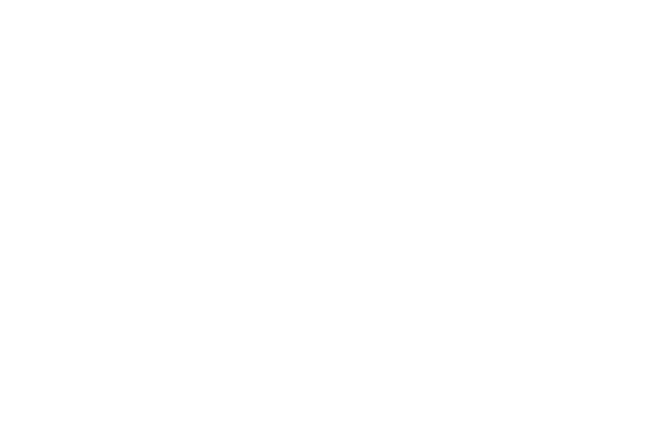

Text(0, 0.5, 'Percentage')

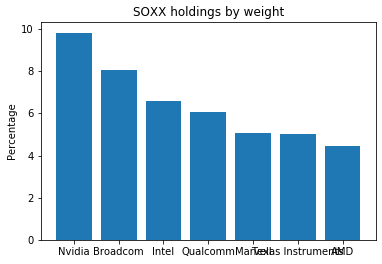

In [38]:
weights = [9.83, 8.06, 6.60, 6.06, 5.07, 5.04, 4.44]
companies = ["Nvidia", "Broadcom", "Intel", "Qualcomm", "Marvell", "Texas Instruments", "AMD"]
plt.bar(companies, weights)
plt.title("SOXX holdings by weight")
plt.ylabel("Percentage")

In [39]:
soxx_data = yf.download("SOXX", start='2021-01-01')
nvda_data = yf.download("NVDA", start='2021-01-01')
tsm_data = yf.download("TSM", start='2021-01-01')
intc_data = yf.download("INTC", start='2021-01-01')
nxpi_data = yf.download("NXPI", start='2021-01-01')
avgo_data = yf.download("AVGO", start='2021-01-01')
txn_data = yf.download("TXN", start='2021-01-01')
amd_data = yf.download("AMD", start='2021-01-01')
gm_data = yf.download("GM", start='2021-01-01')
f_data = yf.download("F", start='2021-01-01')
data_list = [soxx_data, nvda_data, tsm_data, intc_data, nxpi_data, avgo_data, txn_data, amd_data, gm_data, f_data]
data_list_names = ["soxx", "nvda", "tsm", "intc", "nxpi", "avgo", "txn", "amd", "gm", "f"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
soxx_data["Close"].corr(nvda_data["Close"])

0.9542795020315338

In [4]:
soxx_data["Close"].corr(tsmc_data["Close"])

0.015882489095033665

In [5]:
soxx_data["Close"].corr(intc_data["Close"])

-0.5453278457199581

In [6]:
soxx_data["Close"].corr(nxpi_data["Close"])

0.8201669510840811

In [7]:
soxx_data["Close"].corr(avgo_data["Close"])

0.9526388376641379

For each ticker, I proceeded to conduct an Augmented Dickey Fuller test to determine if these trends contained a unit root. With each possible pair of tickers, I also conducted a cointegration test to see if the spread between was stationary, or mean reverting. Additionally, I performed a least-squares regression on the pair and conduced another ADF test on the residuals to gain another perspective of the mean-reverting nature I was hoping to find. By summing the p-values (with lower meaning more attractive pair), I determined the final pair to attempt to trade.

https://palomar.home.ece.ust.hk/MAFS5310_lectures/slides_pairs_trading.pdf

In [49]:
pval = 1
single_pval = 1
coint_val = 1
combo = 2
for i1, ticker1 in enumerate(data_list):
    single_stats = adfuller(ticker1["Close"])
    if single_stats[1] < single_pval:
        single_pval = single_stats[1]
        single_min_ticker = data_list_names[i1]
        single_min = single_stats
    for i2, ticker2 in enumerate(data_list[i1+1:]):
        coint_res = coint(ticker1["Close"], ticker2["Close"])
        if coint_res[1] < coint_val:
            coint_val = coint_res[1]
            coint_pair = data_list_names[i1] + " " + data_list_names[i1+i2+1]
        model = sm.OLS(ticker1["Close"], ticker2["Close"]).fit()
        test_res = adfuller(model.resid)
        if test_res[1] < pval:
            pval = test_res[1]
            pair_tickers = data_list_names[i1] + " " + data_list_names[i1+i2+1]
            pair = test_res
        if test_res[1] + coint_res[1] < combo:
            combo = test_res[1] + coint_res[1]
            combo_tickers = data_list_names[i1] + " " + data_list_names[i1+i2+1]
        
print(single_min_ticker)
print(single_min)
print(" ")
print(pair_tickers)
print(pair)
print(" ")
print(coint_pair)
print(coint_val)   
print(" ")
print(combo_tickers)
print(combo)
    

gm
(-3.5861080455301915, 0.006032233912354138, 0, 235, {'1%': -3.4584868856997004, '5%': -2.873918902362675, '10%': -2.573367247623359}, 725.0405152846421)
 
nxpi txn
(-2.87330845672771, 0.048541067239014024, 4, 231, {'1%': -3.4589796764641, '5%': -2.8741347158661448, '10%': -2.573482381701992}, 1109.1514052282614)
 
soxx nvda
0.0002877851363366099
 
tsm gm
0.10613969814408161


At this point it's relatively straightforward enough to simply compute the mean and standard deviation of some sort of relation between the 2 tickers. I used a ratio of TSM/GM and transacted whenever the ratio had gone more than 1 st. dev away from the mean.

In [50]:
ratio = tsm_data["Close"] / gm_data["Close"]
z_score = (ratio - ratio.mean()) / np.std(ratio)
std_up = np.mean(ratio) + np.std(z_score)
std_down = np.mean(ratio) - np.std(z_score)

x + self.qty1 is 39
y + self.qty2 is 92
2021-02-03T00:00:00, BUY CREATE TXN, price = 127.50, qty = 39
2021-02-03T00:00:00, SELL CREATE NXPI, price = 54.25, qty = 92
2021-02-04T00:00:00, BUY COMPLETE, 127.50
2021-02-04T00:00:00, SELL COMPLETE, 53.34
x + self.qty1 is 74
y + self.qty2 is 185
2021-02-11T00:00:00, SELL CREATE TXN, price = 139.16, qty = 74
2021-02-11T00:00:00, BUY CREATE NXPI, price = 53.50, qty = 185
2021-02-12T00:00:00, SELL COMPLETE, 138.92
2021-02-12T00:00:00, BUY COMPLETE, 53.00
x + self.qty1 is 74
y + self.qty2 is 185
2021-03-02T00:00:00, BUY CREATE TXN, price = 126.00, qty = 74
2021-03-02T00:00:00, SELL CREATE NXPI, price = 54.11, qty = 185
2021-03-03T00:00:00, BUY COMPLETE, 126.72
2021-03-03T00:00:00, SELL COMPLETE, 54.50
x + self.qty1 is 79
y + self.qty2 is 178
2021-04-01T00:00:00, SELL CREATE TXN, price = 124.80, qty = 79
2021-04-01T00:00:00, BUY CREATE NXPI, price = 57.80, qty = 178
2021-04-05T00:00:00, SELL COMPLETE, 127.07
2021-04-05T00:00:00, BUY COMPLETE, 59.0

<IPython.core.display.Javascript object>


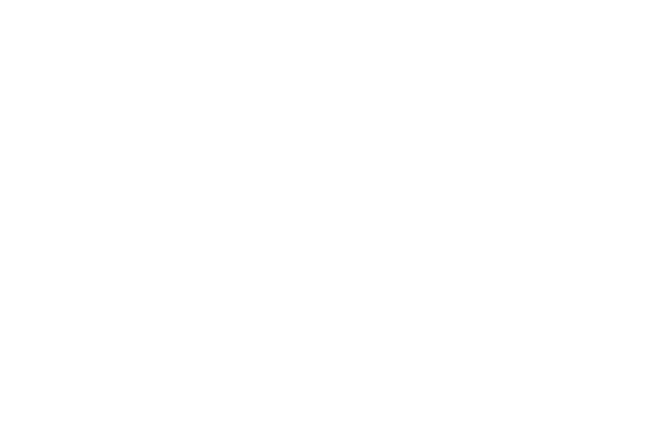

[[<Figure size 432x288 with 7 Axes>]]

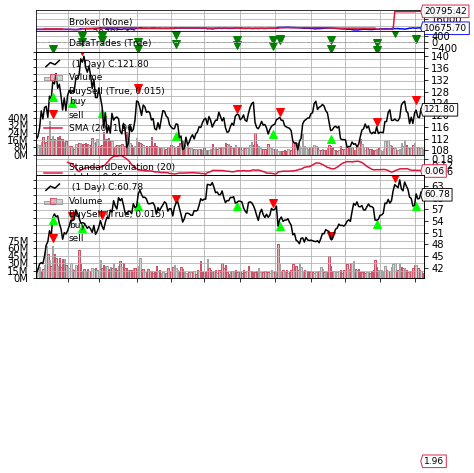

In [48]:
class TSM_GM(bt.Strategy):
    
    params = dict(
        period=10,
        stake=10,
        qty1=0,
        qty2=0,
        printout=True,
        status=0,
        portfolio_value=10000,
    )

    def log(self, txt, dt=None):
        if self.params.printout:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
            return  # Await further notifications

        if order.status == order.Completed:
            if order.isbuy():
                buytxt = 'BUY COMPLETE, %.2f' % order.executed.price
                self.log(buytxt, order.executed.dt)
            else:
                selltxt = 'SELL COMPLETE, %.2f' % order.executed.price
                self.log(selltxt, order.executed.dt)

        elif order.status in [order.Expired, order.Canceled, order.Margin]:
            self.log('%s ,' % order.Status[order.status])
            pass  # Simply log

        # Allow new orders
        self.orderid = False

    def __init__(self):
        # To control operation entries
        self.orderid = False
        self.qty1 = self.params.qty1
        self.qty2 = self.params.qty2
        self.status = self.params.status
        self.portfolio_value = self.params.portfolio_value

        ratio = self.data0.close / self.data1.close
        mean = bt.ind.SMA(ratio, period=20)
        self.z_score = (ratio - mean) / bt.ind.StandardDeviation(ratio)
        

    def next(self):
        if self.orderid != False:
            return  # if an order is active, no new orders are allowed

        if (self.z_score[0] > 1) and (self.status != 1):

            # Calculating the number of shares for each stock
            value = 0.5 * self.portfolio_value  # Divide the cash equally
            x = int(value / (self.data0.close[0]))  # Find the number of shares for Stock1
            y = int(value / (self.data1.close[0]))  # Find the number of shares for Stock2
            print('x + self.qty1 is', x + self.qty1)
            print('y + self.qty2 is', y + self.qty2)

            # Placing the order
            self.log('SELL CREATE %s, price = %.2f, qty = %d' % ("TSM", self.data0.close[0], x + self.qty1))
            self.sell(data=self.data0, size=(x + self.qty1))  # Place an order for buying y + qty2 shares
            self.log('BUY CREATE %s, price = %.2f, qty = %d' % ("GM", self.data1.close[0], y + self.qty2))
            self.buy(data=self.data1, size=(y + self.qty2))  # Place an order for selling x + qty1 shares

            # Updating the counters with new value
            self.qty1 = x  # The new open position quantity for Stock1 is x shares
            self.qty2 = y  # The new open position quantity for Stock2 is y shares

            self.status = 1  # The current status is "short the spread"

            # Step 3: Check conditions for LONG & place the order
            # Checking the condition for LONG
        elif (self.z_score[0] < -1) and (self.status != 2):

            # Calculating the number of shares for each stock
            value = 0.5 * self.portfolio_value  # Divide the cash equally
            x = int(value / (self.data0.close[0]))  # Find the number of shares for Stock1
            y = int(value / (self.data1.close[0]))  # Find the number of shares for Stock2
            print('x + self.qty1 is', x + self.qty1)
            print('y + self.qty2 is', y + self.qty2)

            # Place the order
            self.log('BUY CREATE %s, price = %.2f, qty = %d' % ("TSM", self.data0.close[0], x + self.qty1))
            self.buy(data=self.data0, size=(x + self.qty1))  # Place an order for buying x + qty1 shares
            self.log('SELL CREATE %s, price = %.2f, qty = %d' % ("GM", self.data1.close[0], y + self.qty2))
            self.sell(data=self.data1, size=(y + self.qty2))  # Place an order for selling y + qty2 shares

            # Updating the counters with new value
            self.qty1 = x  # The new open position quantity for Stock1 is x shares
            self.qty2 = y  # The new open position quantity for Stock2 is y shares
            self.status = 2  # The current status is "long the spread"


            # Step 4: Check conditions for No Trade
            # If the z-score is within the two bounds, close all
        
        elif (self.z_score[0] < 1 and self.z_score[0] > -1):
            self.log('CLOSE LONG %s, price = %.2f' % ("TSM", self.data0.close[0]))
            self.close(self.data0)
            self.log('CLOSE LONG %s, price = %.2f' % ("GM", self.data1.close[0]))
            self.close(self.data1)
        

            
    def stop(self):
        print('==================================================')
        print('Starting Value - %.2f' % self.broker.startingcash)
        print('Ending   Value - %.2f' % self.broker.getvalue())
        print('==================================================')



cerebro = bt.Cerebro()
cerebro.addstrategy(TXN_NXPI)
cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.002)

data0 = bt.feeds.PandasData(dataname=tsm_data)
cerebro.adddata(data0)

data1 = bt.feeds.PandasData(dataname=gm_data)
cerebro.adddata(data1)

cerebro.run()
cerebro.plot()